In [1]:
import pandas as pd
import pyreadr

# Load high school data from two sources and merge them
hs_df_old = pyreadr.read_r("../data/raw/HS 23-24 Responses.Rdata")["responses"]
hs_df_new = pyreadr.read_r("../data/raw/HS 23-24 Responses New.Rdata")["responses_HS"]

# Concatenate the two high school dataframes
hs_df = pd.concat([hs_df_old, hs_df_new], ignore_index=True)

In [2]:
# Load college data
college_df = pyreadr.read_r("../data/raw/College 24 Responses v5.3.Rdata")[
    "responses5.3"
]

In [3]:
# keep the book version consistnet
# be careful, need to use regex=False
BOOK_VERSION_INDICATOR = "(ABC)"

In [4]:
set(hs_df["release"])

{'release/v4.1',
 'release/v5.0',
 'release/v5.1',
 'release/v5.1.1',
 'release/v5.2',
 'v5.2',
 'v5.3',
 'v5.4',
 'v5.5',
 'v5.5.1'}

In [5]:
import pandas as pd

pd.set_option("display.max_colwidth", None)

hs_df[["release", "book"]].groupby("release")["book"].agg(list).apply(set)

release
release/v4.1                                                                    {College / Statistics and Data Science (ABC), High School / Advanced Statistics and Data Science I (ABC), High School / Statistics and Data Science I (AB)}
release/v5.0                                                          {College / Advanced Statistics and Data Science (ABCD), High School / Advanced Statistics and Data Science I (ABC), High School / Statistics and Data Science I (AB)}
release/v5.1                                                                                                                                                                             {High School / Statistics and Data Science I (AB)}
release/v5.1.1                                                                                                                                                                           {High School / Statistics and Data Science I (AB)}
release/v5.2                                    

In [6]:
# process hs data
hs_df = hs_df[
    hs_df["release"].isin(
        [
            "release/v5.0",
            "release/v5.1",
            "release/v5.1.1",
            "release/v5.2",
            "v5.2",
            "v5.3",
        ]
    )
]
hs_df = hs_df[hs_df["book"].str.contains(BOOK_VERSION_INDICATOR, regex=False)]
len(hs_df)

576156

In [7]:
set(hs_df["release"])

{'release/v5.0', 'release/v5.2', 'v5.2', 'v5.3'}

In [8]:
# process college data
college_df = college_df[
    college_df["book"].str.contains(BOOK_VERSION_INDICATOR, regex=False)
]
len(college_df)

400437

In [9]:
import pandas as pd

# load the code book
code_book_df = pd.read_csv("../data/raw/Codebook Learning Objectives.csv")

In [10]:
# Check the unique common item ids between repsonse and code book
print("HS: ", len(set(code_book_df.item_id) & set(hs_df.item_id)))
print("College: ", len(set(code_book_df.item_id) & set(college_df.item_id)))
print(
    "HS & College: ",
    len(
        (set(code_book_df.item_id) & set(hs_df.item_id))
        & (set(code_book_df.item_id) & set(college_df.item_id))
    ),
)

HS:  787
College:  786
HS & College:  786


In [11]:
# filter out rows whose points_possible is nan
hs_df = hs_df.dropna(subset=["points_possible"])
college_df = college_df.dropna(subset=["points_possible"])

# Convert points_possible to int for consistent comparison
# the type was inferred as string for some response tables
hs_df["points_possible"] = hs_df["points_possible"].astype(int)
college_df["points_possible"] = college_df["points_possible"].astype(int)

# Filter rows where points_possible is 1
hs_df = hs_df[hs_df["points_possible"] == 1]
college_df = college_df[college_df["points_possible"] == 1]

In [12]:
# check again
# Check the unique common item ids between repsonse and code book
print("HS: ", len(set(code_book_df.item_id) & set(hs_df.item_id)))
print("College: ", len(set(code_book_df.item_id) & set(college_df.item_id)))
print(
    "HS & College: ",
    len(
        (set(code_book_df.item_id) & set(hs_df.item_id))
        & (set(code_book_df.item_id) & set(college_df.item_id))
    ),
)

# diff between hs and college
print(
    "HS - College: ",
    (set(code_book_df.item_id) & set(hs_df.item_id))
    - (set(code_book_df.item_id) & set(college_df.item_id)),
)

HS:  700
College:  698
HS & College:  698
HS - College:  {'b2_Sum_11', 'B4_Shuffle_01'}


In [13]:
# Do the actual filtering based on id_p, which is the concategation of item_id and lrn_question_position

# Setup a new column called id_p
hs_df["id_p"] = (
    hs_df["item_id"].astype(str) + " " + hs_df["lrn_question_position"].astype(str)
)
college_df["id_p"] = (
    college_df["item_id"].astype(str)
    + " "
    + college_df["lrn_question_position"].astype(str)
)

# filter the response based on id_p
hs_df = hs_df[hs_df["id_p"].isin(set(code_book_df["id_p"]))]
college_df = college_df[college_df["id_p"].isin(set(code_book_df["id_p"]))]

In [14]:
# number of unique questions with possible points = 1
print(len(set(hs_df["id_p"])))
print(len(set(college_df["id_p"])))

547
546


In [15]:
# get common questions
unique_questions = set(hs_df["id_p"]) & set(college_df["id_p"])
len(unique_questions)

546

In [16]:
# Only keep the common questions from the responses
hs_df = hs_df[hs_df["id_p"].isin(unique_questions)]
college_df = college_df[college_df["id_p"].isin(unique_questions)]

In [17]:
print(len(hs_df))
print(len(college_df))

231380
157429


# Completion Rate

In [18]:
def get_student_completion_rate(df):
    """
    Calculate the completion rate of the students by:
    questions students attempted / total questions * 100.

    The output contains:
    1. a table of completion rates for each student
    2. a dictionary of completion rates for each bucket
    """
    unique_student_count = len(df["student_id"].unique())
    unique_question_count = len(df["id_p"].unique())

    questions_per_student = df.groupby("student_id")["id_p"].nunique()
    completion_rates = questions_per_student / len(unique_questions) * 100

    completion_buckets = pd.cut(
        completion_rates,
        bins=[0, 20, 40, 60, 80, 100],
        labels=["0-20", "20-40", "40-60", "60-80", "80-100"],
    )
    bucket_percentages = completion_buckets.value_counts(normalize=True) * 100

    # keep two decimal places
    bucket_percentages = bucket_percentages.round(2)

    # Create result dictionary
    result = {
        "completion_rate_0-20_pct": bucket_percentages.get("0-20", 0),
        "completion_rate_20-40_pct": bucket_percentages.get("20-40", 0),
        "completion_rate_40-60_pct": bucket_percentages.get("40-60", 0),
        "completion_rate_60-80_pct": bucket_percentages.get("60-80", 0),
        "completion_rate_80-100_pct": bucket_percentages.get("80-100", 0),
        "unique_student_count": unique_student_count,
        "unique_question_count": unique_question_count,
    }

    return completion_rates, result

In [ ]:
import rich

hs_completion_rate, hs_completion_rate_result = get_student_completion_rate(hs_df)
college_completion_rate, college_completion_rate_result = get_student_completion_rate(
    college_df
)

rich.print(hs_completion_rate_result)
rich.print(college_completion_rate_result)

{
    'completion_rate_0-20_pct': 45.74,
    'completion_rate_20-40_pct': 28.64,
    'completion_rate_40-60_pct': 9.29,
    'completion_rate_60-80_pct': 8.87,
    'completion_rate_80-100_pct': 7.46,
    'unique_student_count': 1421,
    'unique_question_count': 546
}

{
    'completion_rate_0-20_pct': 21.11,
    'completion_rate_20-40_pct': 16.3,
    'completion_rate_40-60_pct': 19.44,
    'completion_rate_60-80_pct': 9.81,
    'completion_rate_80-100_pct': 33.33,
    'unique_student_count': 540,
    'unique_question_count': 546
}

In [32]:
# Plot a histogram based on hs_completion_rate
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib retina mode
%config InlineBackend.figure_format = 'retina'

# set seaborn style
sns.set_style("whitegrid")


def plot_completion_rate_histogram(completion_rate, title):
    plt.figure(figsize=(10, 6))
    plt.hist(completion_rate, bins=5, edgecolor="black")
    plt.xlabel("Completion Rate (%)")
    plt.ylabel("Number of Students")
    plt.title(f"Distribution of Student Completion Rates ({title})")
    # plt.grid(True)
    plt.show()

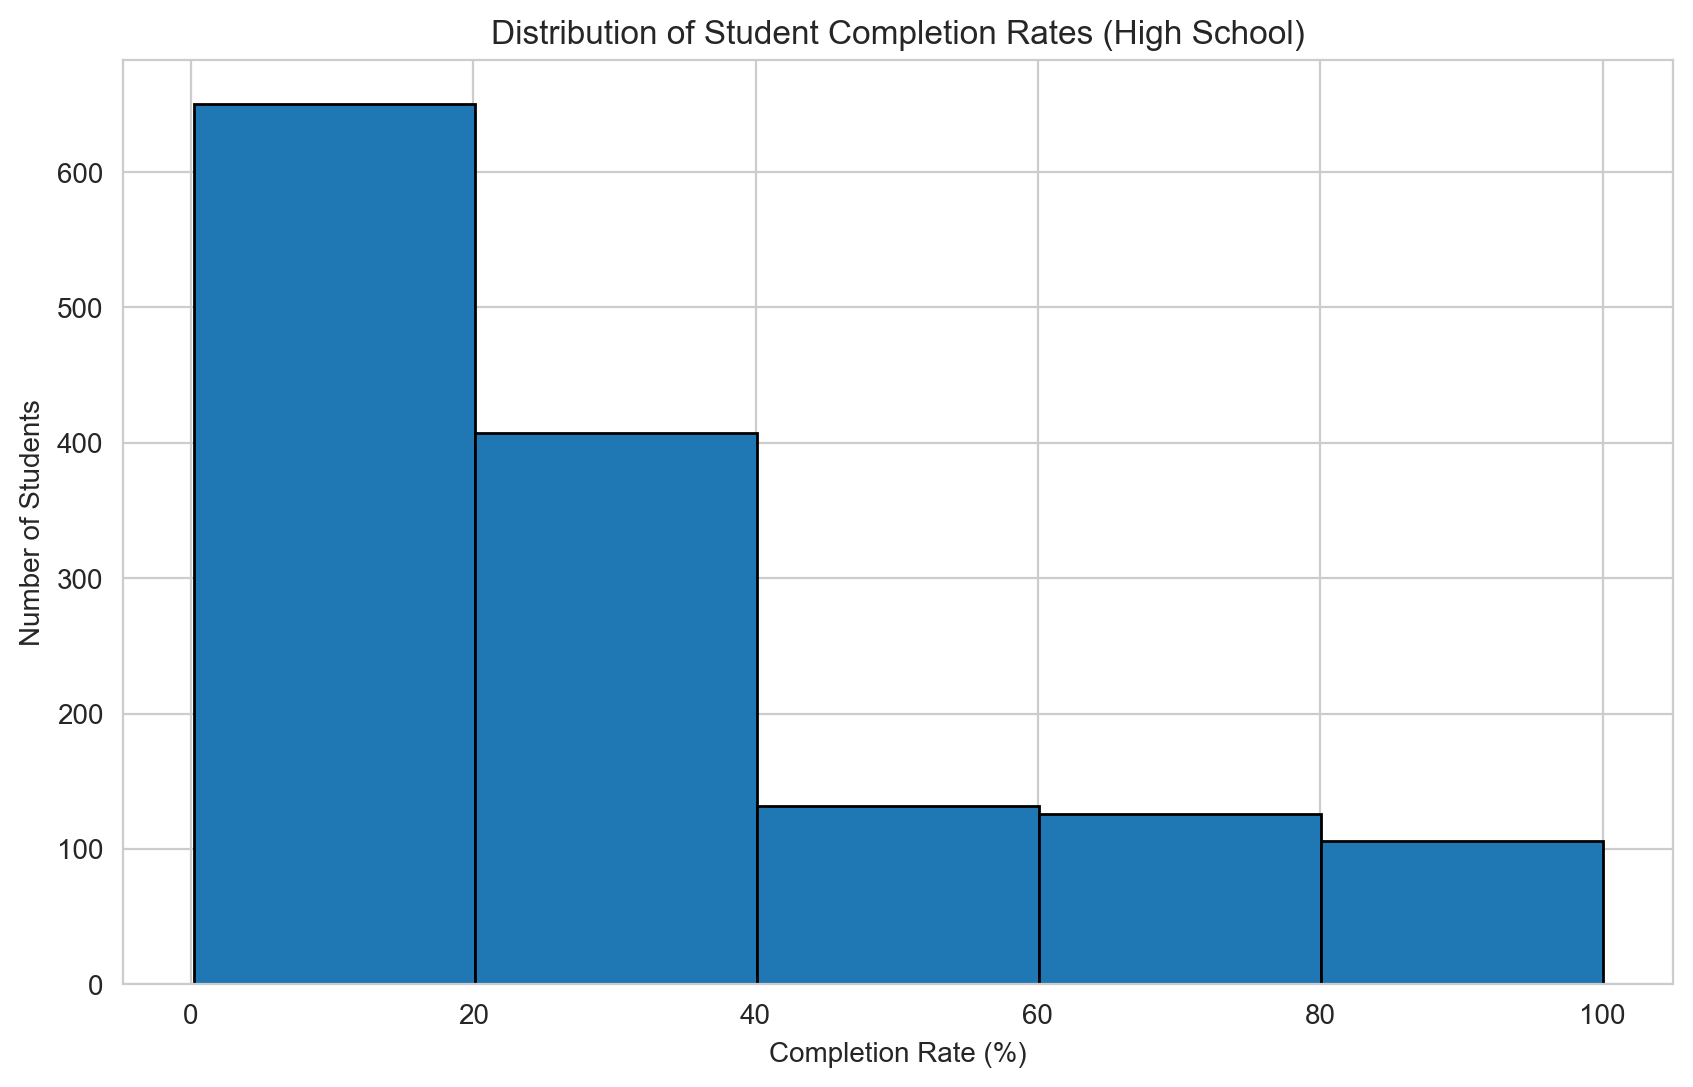

In [ ]:
plot_completion_rate_histogram(hs_completion_rate, "High School")

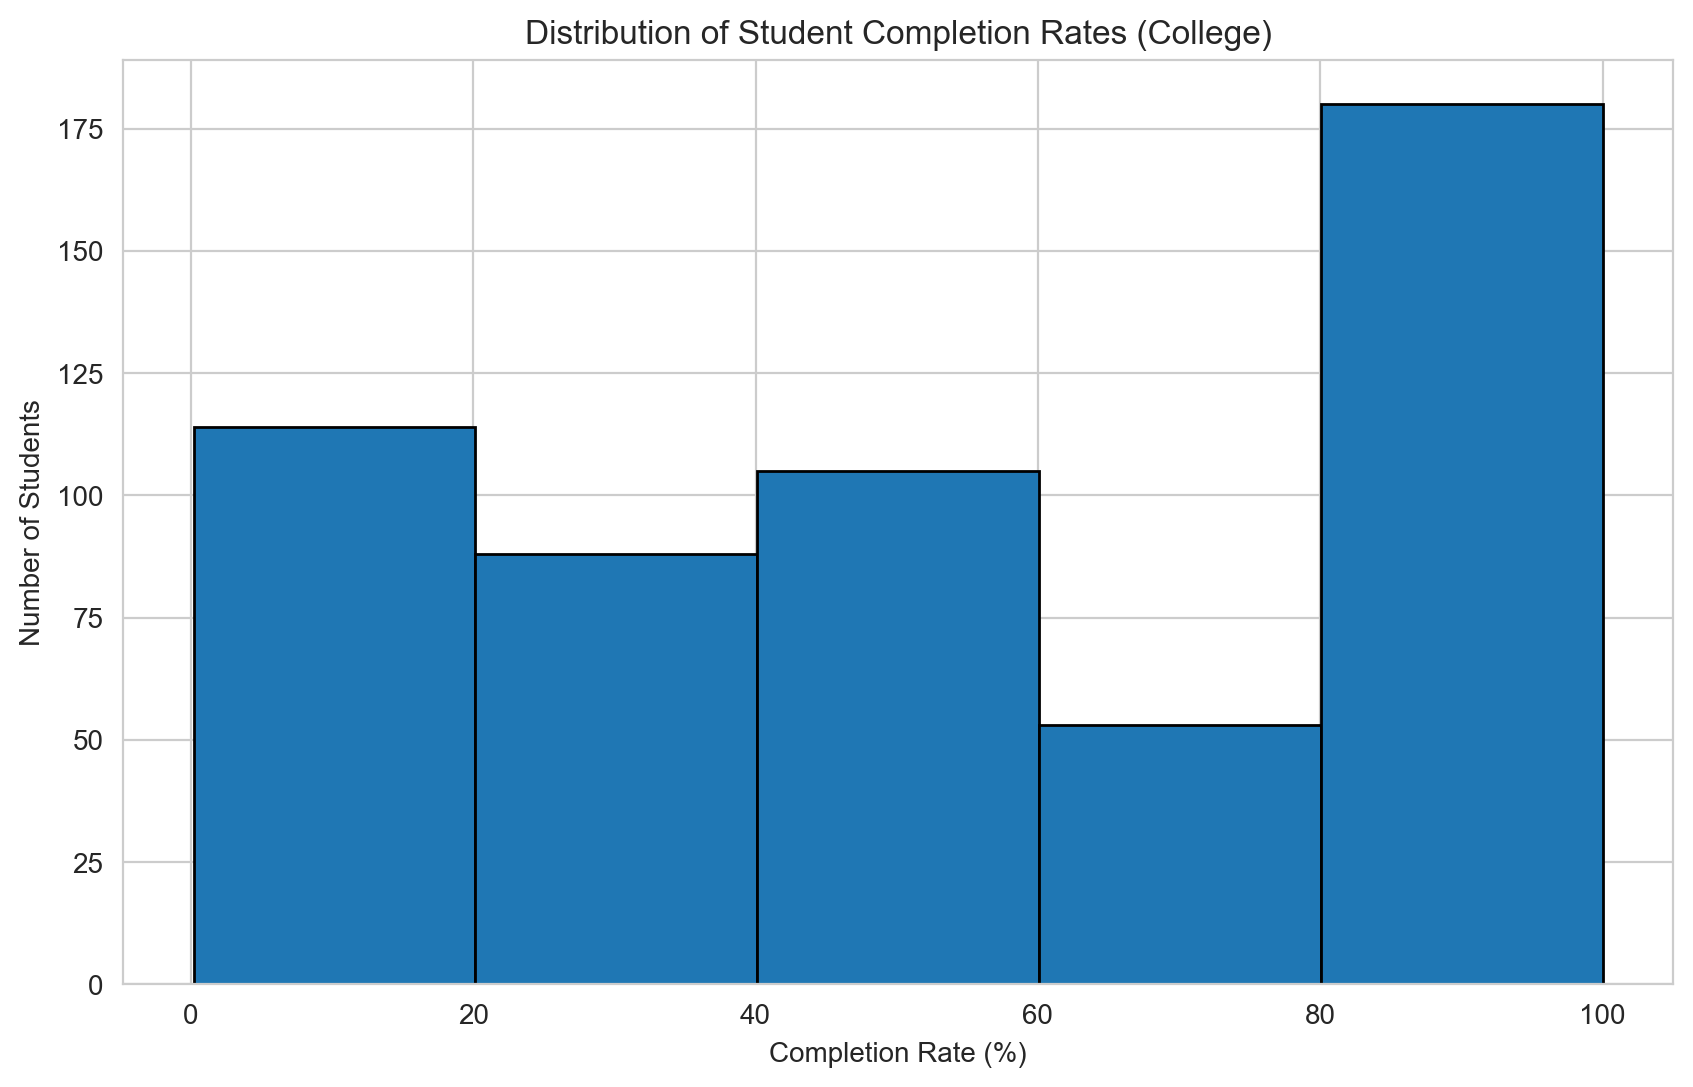

In [ ]:
plot_completion_rate_histogram(college_completion_rate, "College")

# Max score

In [43]:
def get_student_max_scores(df):
    """
    Generate a table where each row is a student and each column is a question. The value is the max score for the corresponding question.
    """
    df["points_earned"] = df["points_earned"].astype(int)

    # Get unique questions from the dataframe
    unique_questions = df["id_p"].unique()

    # Group by student_id and id_p to get max points for each student-question pair
    max_scores = df.groupby(["student_id", "id_p"])["points_earned"].max().reset_index()

    # Pivot the table to get questions as columns and students as rows
    student_scores = max_scores.pivot(
        index="student_id", columns="id_p", values="points_earned"
    )

    # Add missing question columns with NULL values
    missing_questions = set(unique_questions) - set(student_scores.columns)
    for q in missing_questions:
        student_scores[q] = None

    return student_scores

In [45]:
hs_student_performance = get_student_max_scores(hs_df)
college_student_performance = get_student_max_scores(college_df)

In [46]:
# save the student performance
hs_student_performance.to_csv("all_hs_student_performance.csv", index=False)
college_student_performance.to_csv("all_college_student_performance.csv", index=False)

In [47]:
# Compute the mean score across questions for each student

# Convert string values to numeric before calculating mean
hs_student_performance = hs_student_performance.apply(pd.to_numeric, errors="coerce")
college_student_performance = college_student_performance.apply(
    pd.to_numeric, errors="coerce"
)

# Now calculate the mean
hs_student_performance_avg = hs_student_performance.mean(axis=1, skipna=True)
college_student_performance_avg = college_student_performance.mean(axis=1, skipna=True)

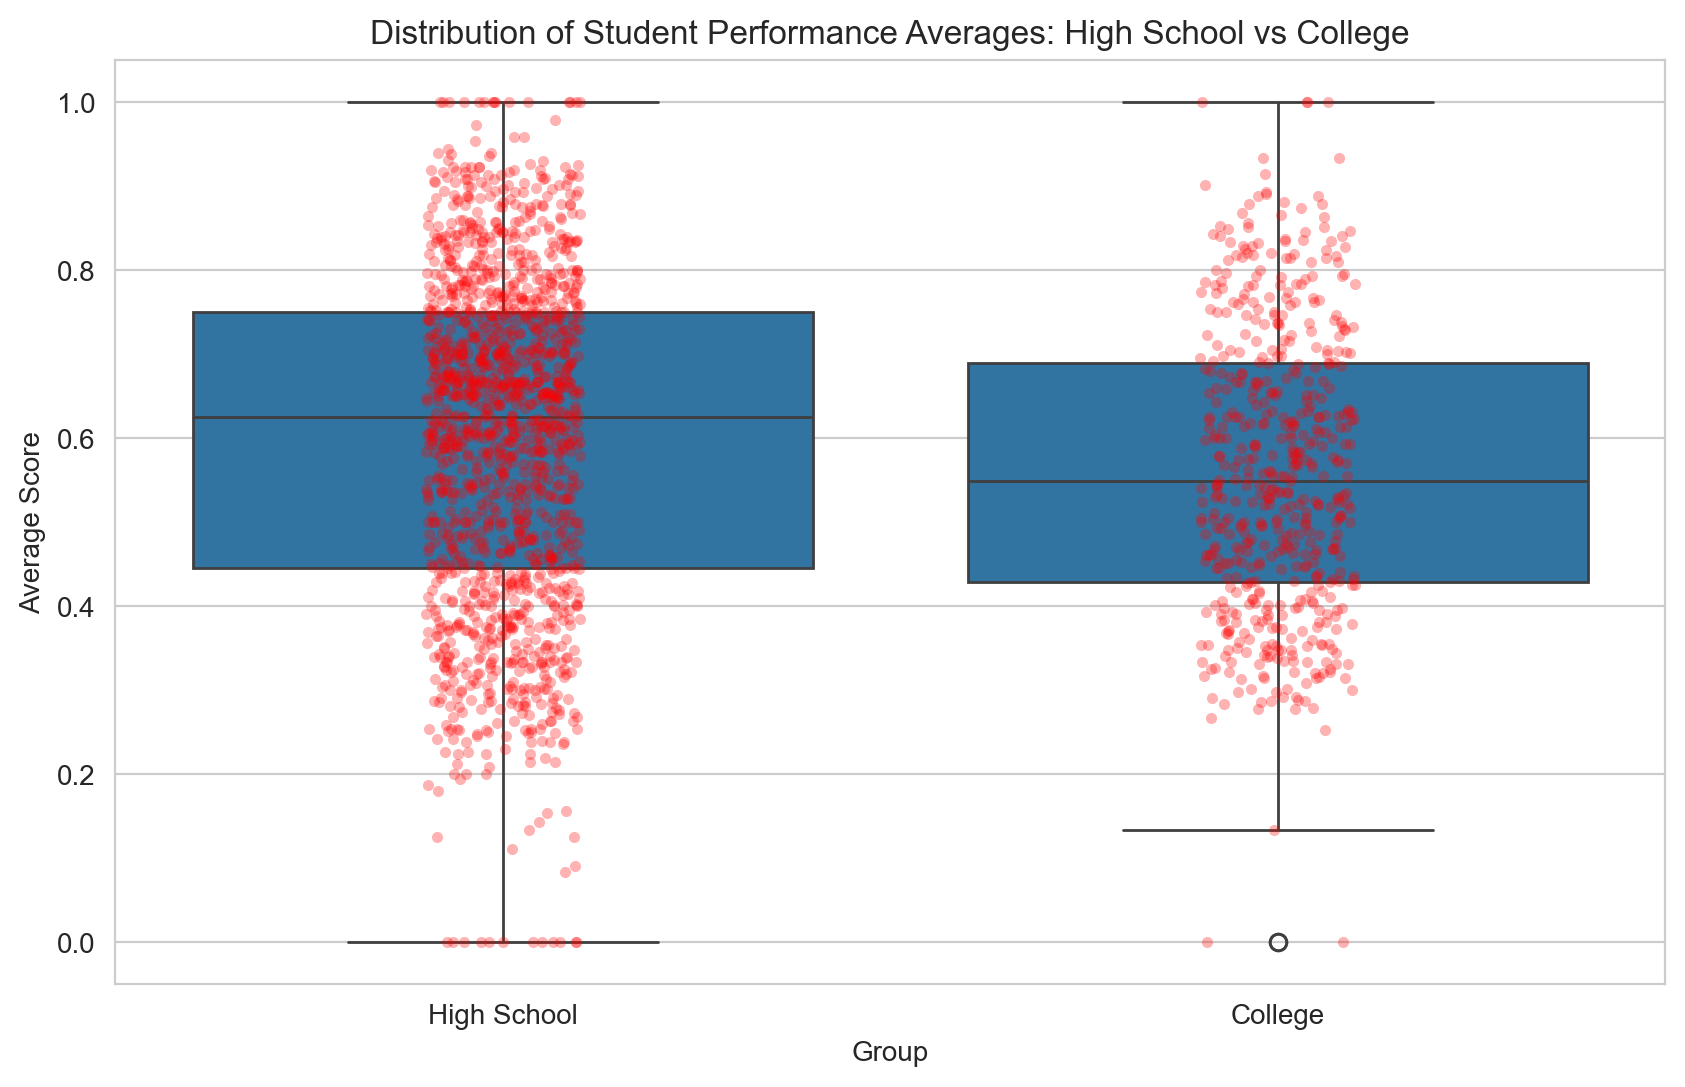

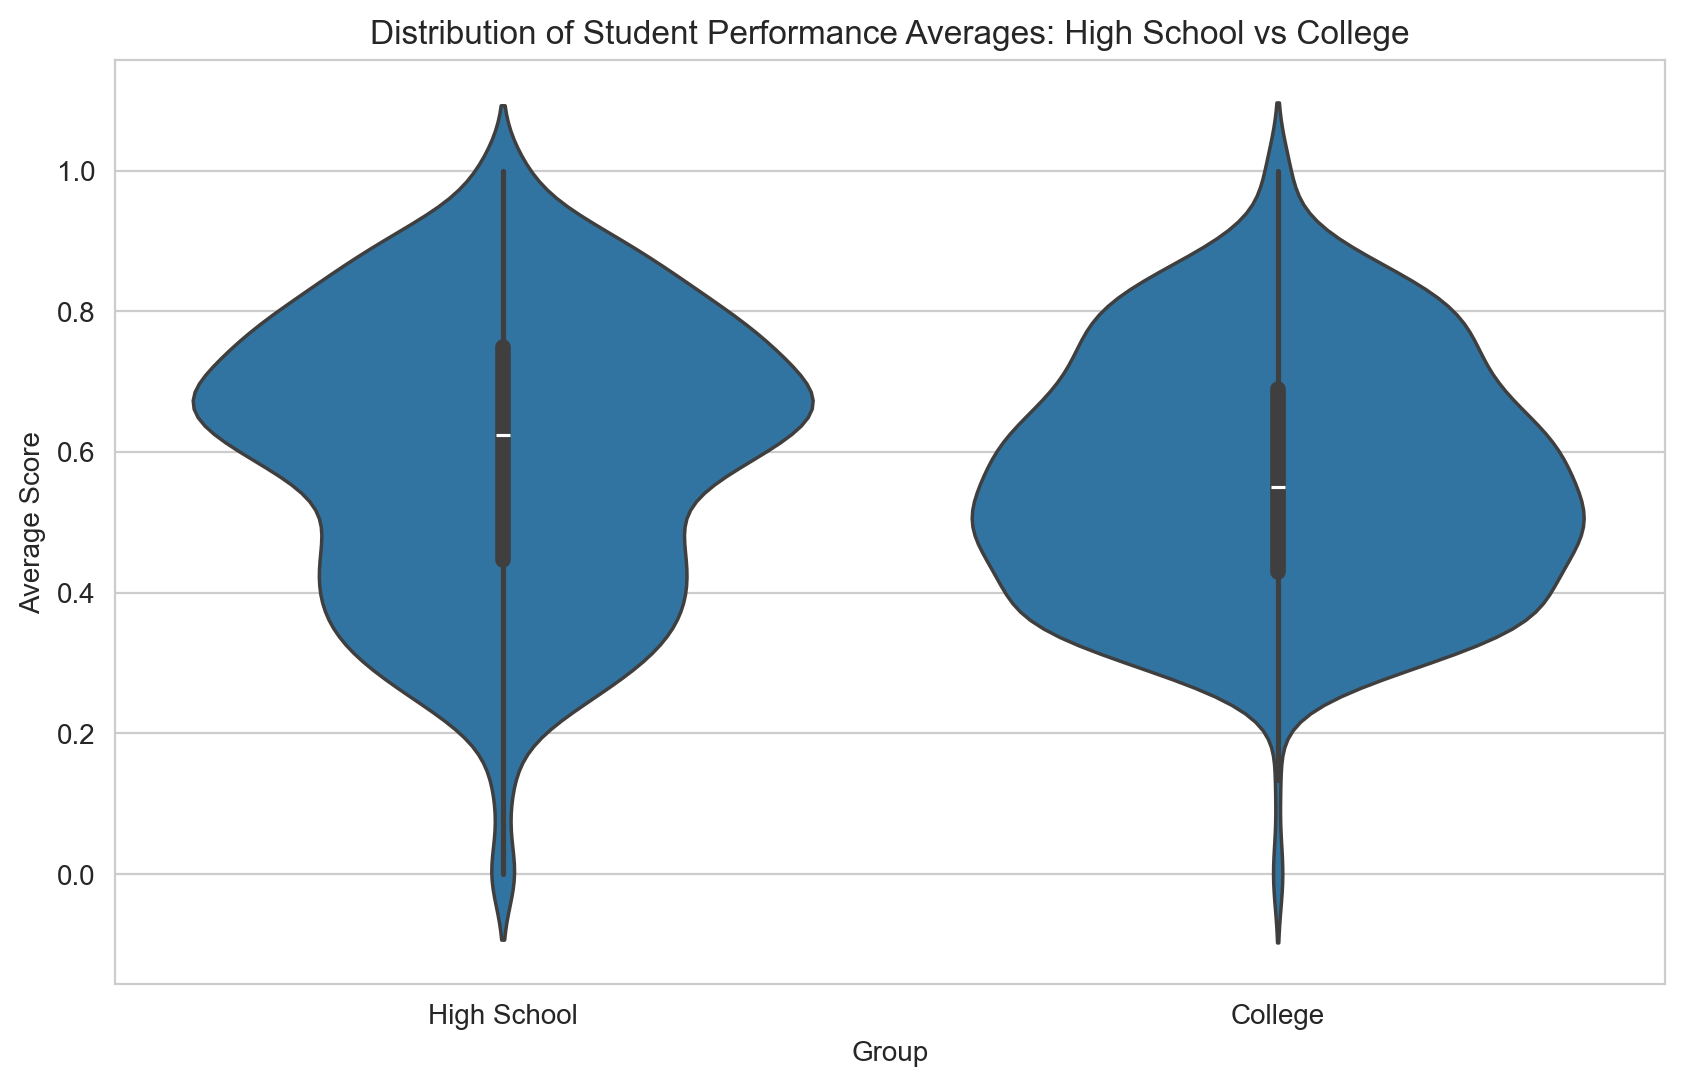

In [ ]:
# Create a DataFrame for plotting
import seaborn as sns
from matplotlib import pyplot as plt

plot_data = pd.DataFrame(
    {
        "Average Score": pd.concat(
            [hs_student_performance_avg, college_student_performance_avg]
        ),
        "Group": ["High School"] * len(hs_student_performance_avg)
        + ["College"] * len(college_student_performance_avg),
    }
)

# Create the distribution plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=plot_data, x="Group", y="Average Score")
sns.stripplot(
    data=plot_data, x="Group", y="Average Score", color="red", alpha=0.3, size=4
)

plt.title("Distribution of Student Performance Averages: High School vs College")
plt.ylabel("Average Score")
plt.show()

# Also create a violin plot for better visualization of the distribution
plt.figure(figsize=(10, 6))
sns.violinplot(data=plot_data, x="Group", y="Average Score")
plt.title("Distribution of Student Performance Averages: High School vs College")
plt.ylabel("Average Score")
plt.show()

In [49]:
# Perform independent t-test to compare HS vs College performance
from scipy import stats

t_stat, p_value = stats.ttest_ind(
    hs_student_performance_avg.dropna(), college_student_performance_avg.dropna()
)

print("\nIndependent t-test results:")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

# Print mean scores for each group
print("\nMean scores:")
print(f"High School: {hs_student_performance_avg.mean():.4f}")
print(f"College: {college_student_performance_avg.mean():.4f}")


Independent t-test results:
t-statistic: 3.7926
p-value: 0.0002

Mean scores:
High School: 0.5988
College: 0.5620


hs_student_performance

In [64]:
# compute the mean score for each student, skipping NaN both in denominator and numerator
hs_student_performance_avg = hs_student_performance.mean(axis=1, skipna=True)
college_student_performance_avg = college_student_performance.mean(axis=1, skipna=True)

In [69]:
# Join the two series into a dataframe as two columns
hs_student_perf_and_completion = pd.DataFrame(
    {"mean_score": hs_student_performance_avg, "completion_rate": hs_completion_rate}
)
hs_student_perf_and_completion

college_student_perf_and_completion = pd.DataFrame(
    {
        "mean_score": college_student_performance_avg,
        "completion_rate": college_completion_rate,
    }
)
college_student_perf_and_completion

,mean_score,completion_rate
student_id,,
0085576f-c6cc-484c-bfcf-6405f386fbdb,0.774869,34.981685
00fa353b-9cec-4df6-a456-14d5903c9094,0.498168,100.000000
00fb95d6-5b83-4c28-8ffc-3b3365500860,0.355450,77.289377
013a77d4-ad4c-473c-9423-d16af4170251,0.593857,53.663004
01c79ac9-aa40-453c-9383-f6efd345b838,0.418060,54.761905
...,...,...
fe5d1975-1ab6-4f3d-b56c-78a3c9485a3b,0.612676,78.021978
fe771baa-b428-4f74-976c-e8a73f7644eb,0.430034,53.663004
fe9c0cd2-5c96-4f4d-a5b2-c48e2cd89dfd,0.890411,80.219780


In [70]:
# Create completion rate buckets
def add_completion_bucket(df):
    df = df.copy()
    df["completion_bucket"] = pd.cut(
        df["completion_rate"],
        bins=[0, 20, 40, 60, 80, 100],
        labels=["0-20", "20-40", "40-60", "60-80", "80+"],
        include_lowest=True,
    )
    return df


# Add buckets to both dataframes
hs_data = add_completion_bucket(hs_student_perf_and_completion)
college_data = add_completion_bucket(college_student_perf_and_completion)

# Prepare data for plotting
hs_plot_data = hs_data.assign(group="High School")
college_plot_data = college_data.assign(group="College")
plot_data = pd.concat([hs_plot_data, college_plot_data])

In [71]:
plot_data

,mean_score,completion_rate,completion_bucket,group
student_id,,,,
003400b4-d908-44bb-8b2c-96fc795b51ca,0.367188,23.443223,20-40,High School
003e5403-d7f3-4667-8e75-8bca4b35d72a,0.643678,31.868132,20-40,High School
006a2cec-e226-40a1-8471-06ad6ddbed3e,0.662921,16.300366,0-20,High School
007aebf9-9b12-4739-97cc-71ef9aafdf06,0.684211,41.758242,40-60,High School
009b2326-fa15-47a1-b34c-2f236def3613,0.260870,8.424908,0-20,High School
...,...,...,...,...
fe5d1975-1ab6-4f3d-b56c-78a3c9485a3b,0.612676,78.021978,60-80,College
fe771baa-b428-4f74-976c-e8a73f7644eb,0.430034,53.663004,40-60,College
fe9c0cd2-5c96-4f4d-a5b2-c48e2cd89dfd,0.890411,80.219780,80+,College


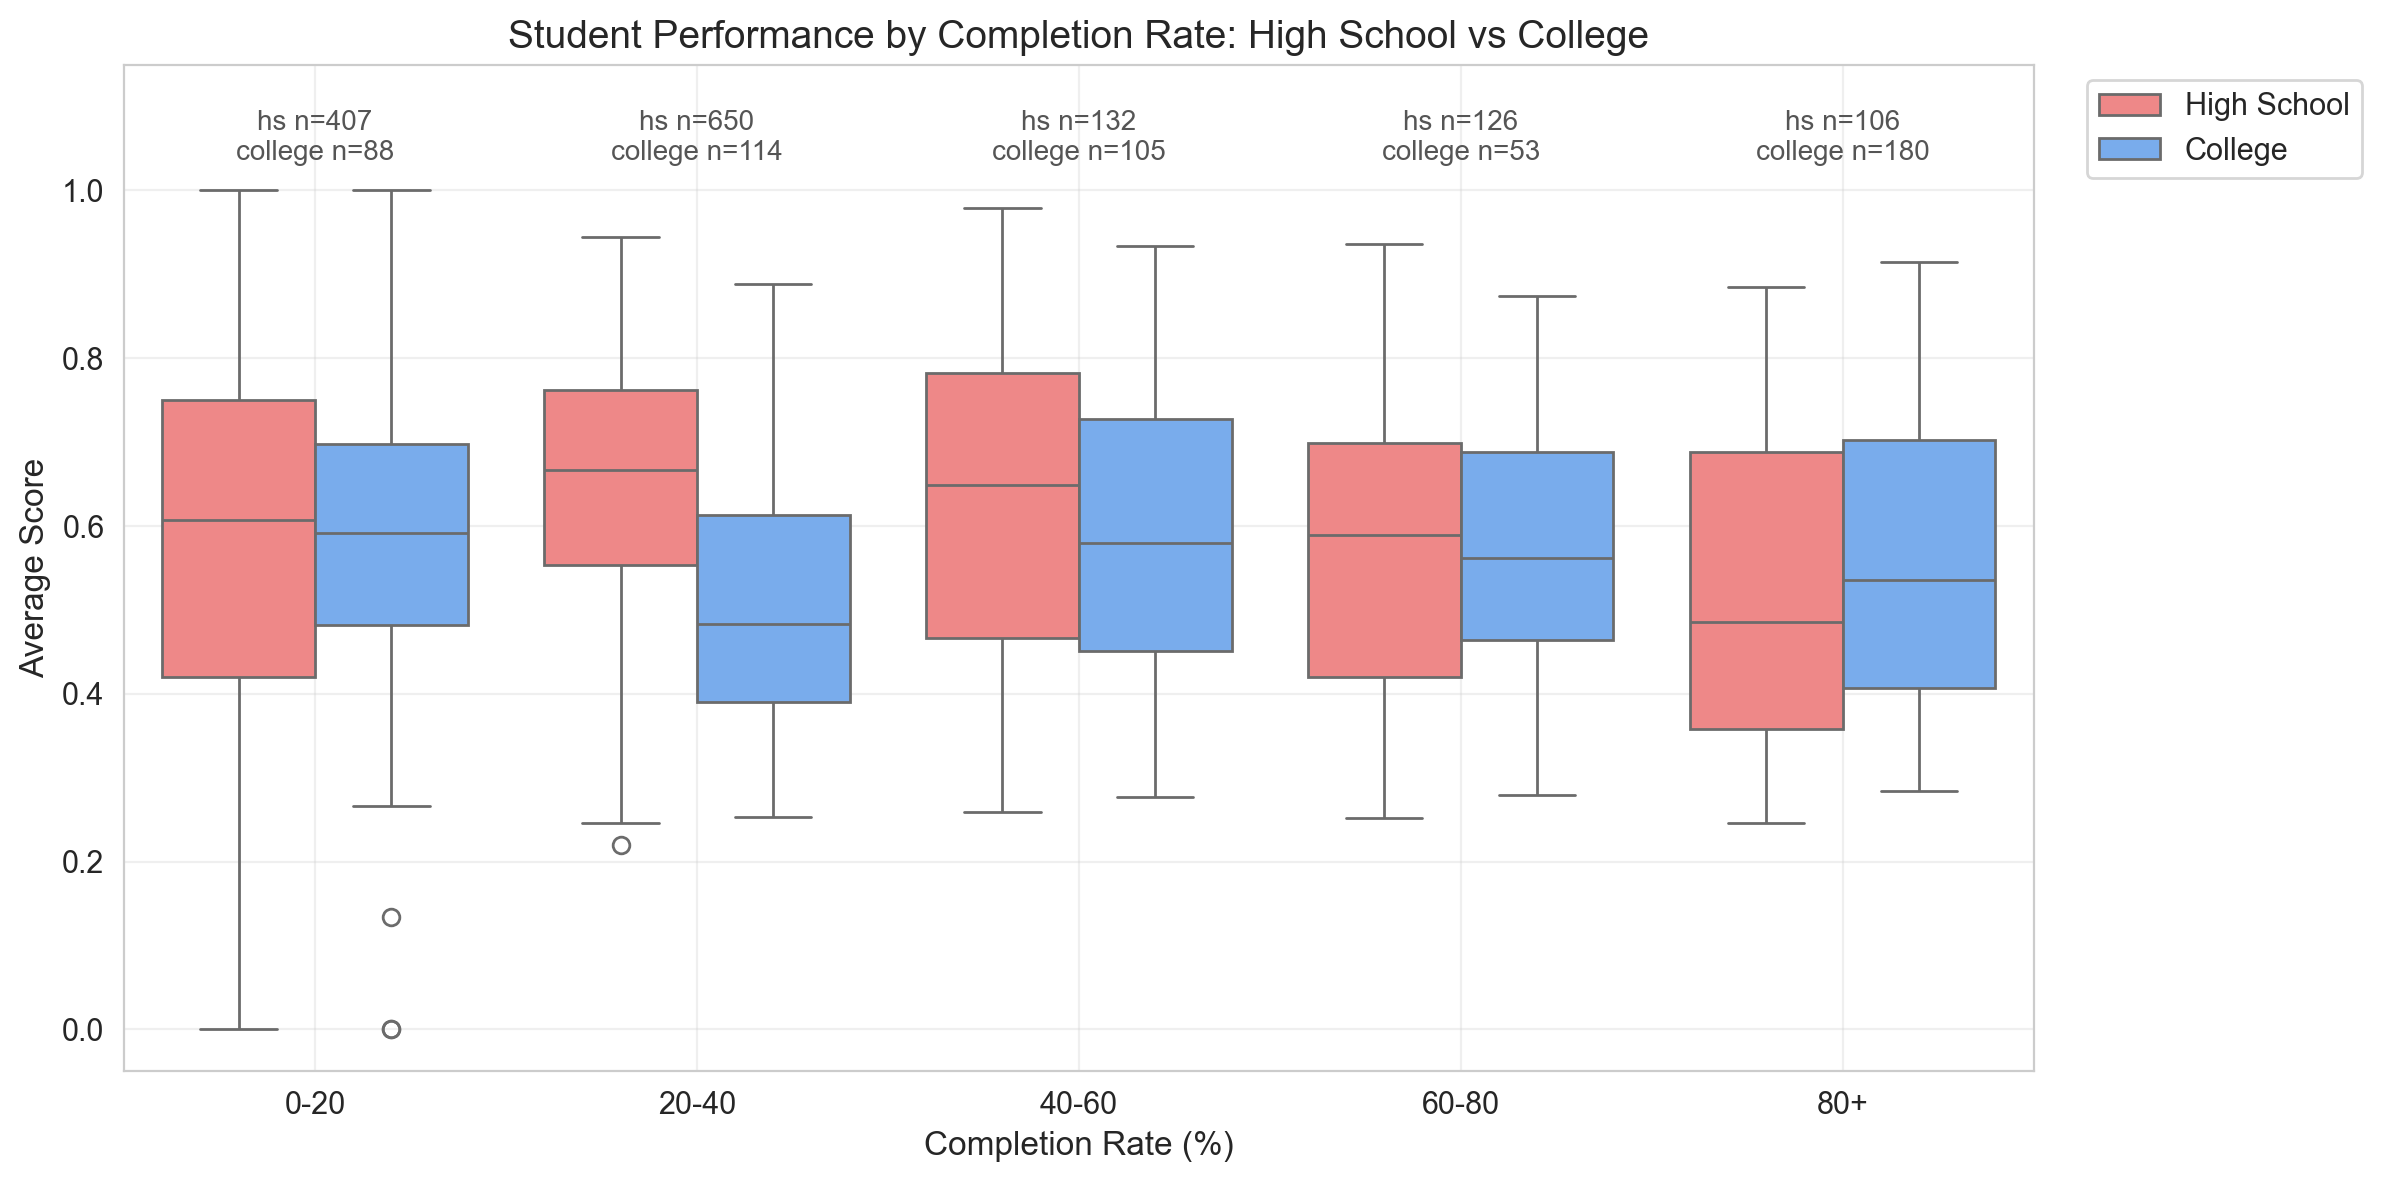

In [97]:
# Create the plot
plt.figure(figsize=(12, 6))

# Use a more muted color palette
sns.boxplot(
    data=plot_data,
    x="completion_bucket",
    y="mean_score",
    hue="group",
    palette={"High School": "#ff7777", "College": "#66aaff"},
    width=0.8,
)

# Customize the plot
plt.title("Student Performance by Completion Rate: High School vs College", fontsize=14)
plt.xlabel("Completion Rate (%)", fontsize=12)
plt.ylabel("Average Score", fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Move legend to a better position and increase font size
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=11)

# Add number of students in each bucket as annotations with better formatting
for bucket in plot_data["completion_bucket"].unique():
    hs_count = len(hs_data[hs_data["completion_bucket"] == bucket])
    college_count = len(college_data[college_data["completion_bucket"] == bucket])
    bucket_idx = plot_data["completion_bucket"].unique().tolist().index(bucket)

    # Position annotations above the plot
    plt.text(
        bucket_idx,
        plt.ylim()[1] - 0.02,  # Position above the top of the plot
        f"hs n={hs_count}\ncollege n={college_count}",
        ha="center",
        va="bottom",
        fontsize=10,
        color="#555555",
    )

# Adjust y-axis limits to make room for annotations
plt.ylim(plt.ylim()[0], plt.ylim()[1] + 0.1)  # Add 10% more space at the top

# Adjust layout to prevent legend cutoff
plt.tight_layout()
plt.show()